## Model

In this notebook, we analyse feature importances and train a model to preform the desired prediction task.

Due to the relatively small size of the dataset, we use Random Forests as our main tool in this notebook, with gradient boosted trees as our final prediction model.

We run hyperparameter optimization with the two methods described in [Feature Engineering](feature-engineering.ipynb): 
- Diagnosis information only distinguishes between diabetes or no diabetes
- Full diagnosis information

The full results can be seen below.

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hypopt import GridSearch
from sklearn.neural_network import MLPClassifier

In [5]:
def read_data(filename, data_dir='data'):
    df = pd.read_csv(os.path.join(data_dir, filename), index_col=0)
    df.fillna('?', inplace=True)
    return df

df_train = read_data('diab_train_filtered.csv')
df_val = read_data('diab_validation_filtered.csv')
df_test = read_data('diab_test_filtered.csv')
df_train_alt = read_data('diab_train_alt.csv')
df_val_alt = read_data('diab_validation_alt.csv')
df_test_alt = read_data('diab_test_alt.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 9011 to 1625
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      6000 non-null   object
 1   gender                    6000 non-null   object
 2   age                       6000 non-null   object
 3   admission_type_id         6000 non-null   object
 4   discharge_disposition_id  6000 non-null   object
 5   admission_source_id       6000 non-null   object
 6   time_in_hospital          6000 non-null   int64 
 7   num_lab_procedures        6000 non-null   int64 
 8   num_procedures            6000 non-null   int64 
 9   num_medications           6000 non-null   int64 
 10  number_outpatient         6000 non-null   int64 
 11  number_emergency          6000 non-null   int64 
 12  number_inpatient          6000 non-null   int64 
 13  diag_1                    6000 non-null   object
 14  number_diagnoses     

In [6]:
df_train.age.value_counts()

[70-80)      1550
[60-70)      1330
[80-100)]    1129
[50-60)      1024
[0-50)        967
Name: age, dtype: int64

### Prepare data

We replace categorical variables by one-hot encodings. 

Numerical data gets scaled by subtracting by the mean and dividing by the standard deviation calculated on the training set.

Text and diagnosis data has already been vectorized previously.

In [7]:
def prepare_data(df, scaler, categorical_vars, numerical_vars):
    categoricals = df.loc[:, categorical_vars]
    ## rename values with >, [, ] for xgboost
    categoricals.max_glu_serum = categoricals.max_glu_serum.replace({'>200': 'greater_200', '>300': 'greater_300'})
    categoricals.A1Cresult = categoricals.A1Cresult.replace({'>8': 'greater_8', '>7': 'greater_7'})
    categoricals.age = categoricals.age.str.replace('[', '(')
    categoricals.age = categoricals.age.str.replace(']', ')')
    categoricals = pd.get_dummies(categoricals)
    y = df.readmitted
    x = df.drop(columns=['readmitted', 'diag_1_desc'] + categorical_vars)
    x[numerical_vars] = scaler.transform(x[numerical_vars])
    x = x.join(categoricals)
    
    return x, y

In [8]:
categorical_vars = ['race', 'age', 'gender', 'diag_1', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', \
                    'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
numerical_vars = df_train.columns[6:13].tolist() + [df_train.columns[14]]

scaler = StandardScaler()
scaler.fit(df_train[numerical_vars])

X_train, Y_train = prepare_data(df_train, scaler, categorical_vars, numerical_vars)
X_val, Y_val = prepare_data(df_val, scaler, categorical_vars, numerical_vars)
X_test, Y_test = prepare_data(df_test, scaler, categorical_vars, numerical_vars)

In [9]:
X_train.shape, X_test.shape, X_val.shape

((6000, 93), (2000, 93), (2000, 93))

## Feature Importance
We train a Random Forest Classifier and extract the feature importances. This is plotted in the graph below.

We find that the number of lab procedures, number of medications, time in hospital, number of diagnostics and number of procedures and number inpatients seem to be the most relevant features. These features make intuitive sense. Patients that had to undertake more lab procedures, took more medication and spent more time in the hospital most likely had more aggravated prognostics. Simarly, patients that had to undertake many procedures and visited the hospital many times were likely in worse health.

By training models that start by using only the most important feature, and successively add the next most important one, and plotting their validation and train accuracy, we see that using these less important features leads the model to aggressively overfitting.

0.6525


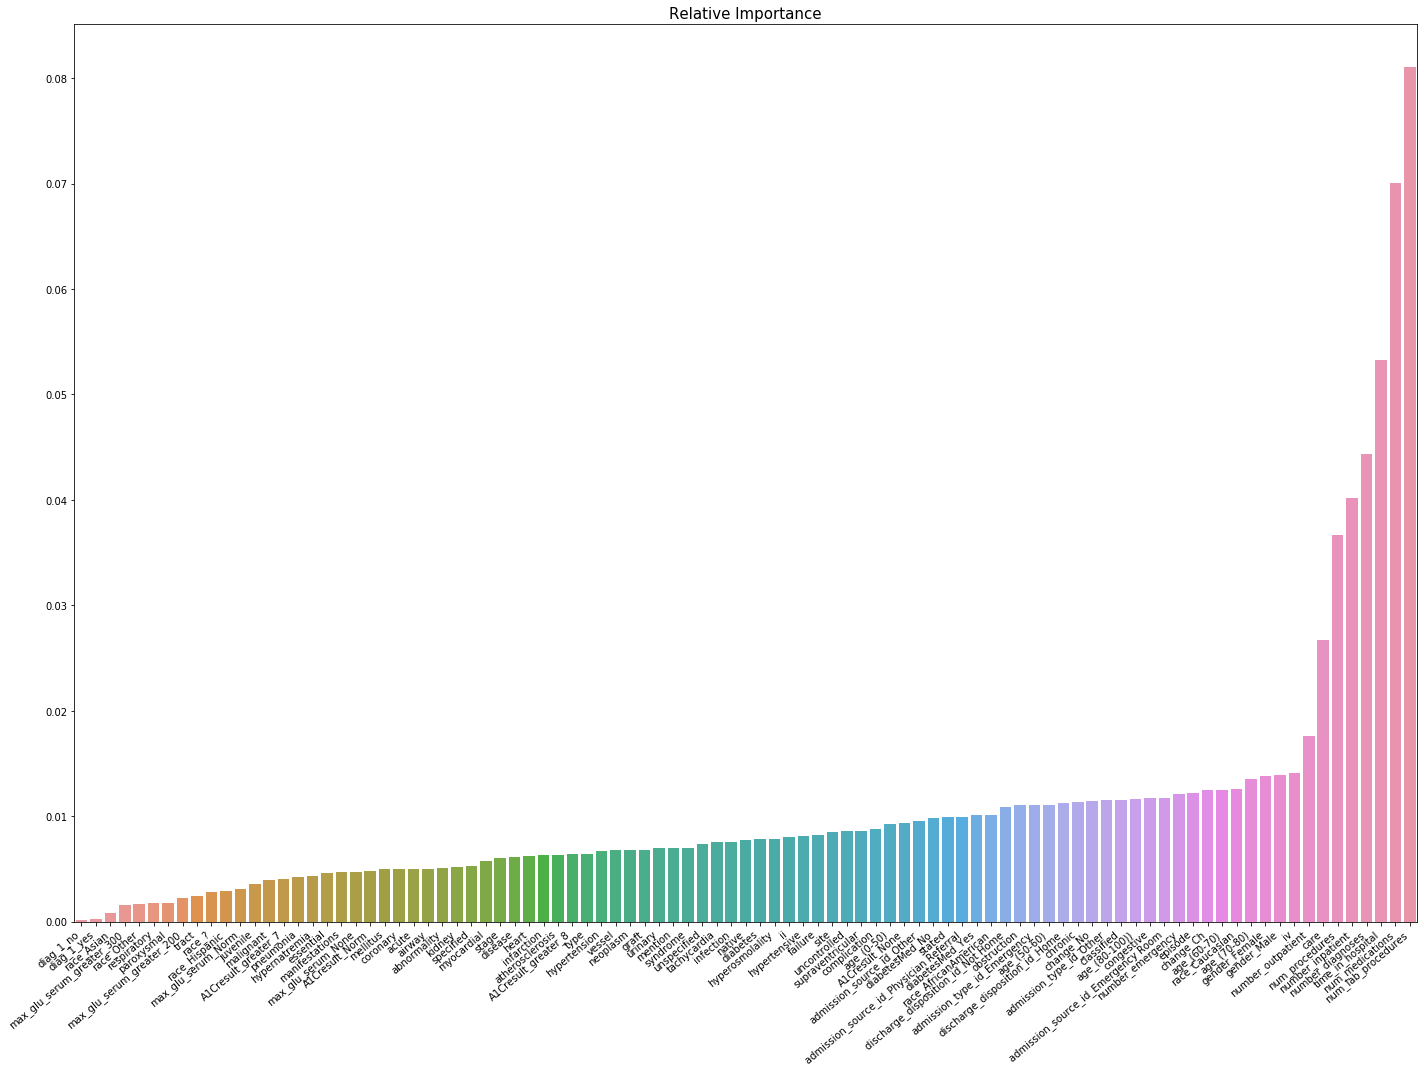

In [10]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, Y_train)
print(clf.score(X_val, Y_val))
importances = clf.feature_importances_

relative = 100 * (importances / importances.max())
indices = np.argsort(importances)
features = X_train.columns.values.tolist()
feature_names_sort = [features[i] for i in indices]

plt.figure(figsize=(20, 15))
plt.title('Relative Importance', fontsize=15)
ax = sns.barplot(x=feature_names_sort, y=importances[indices])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

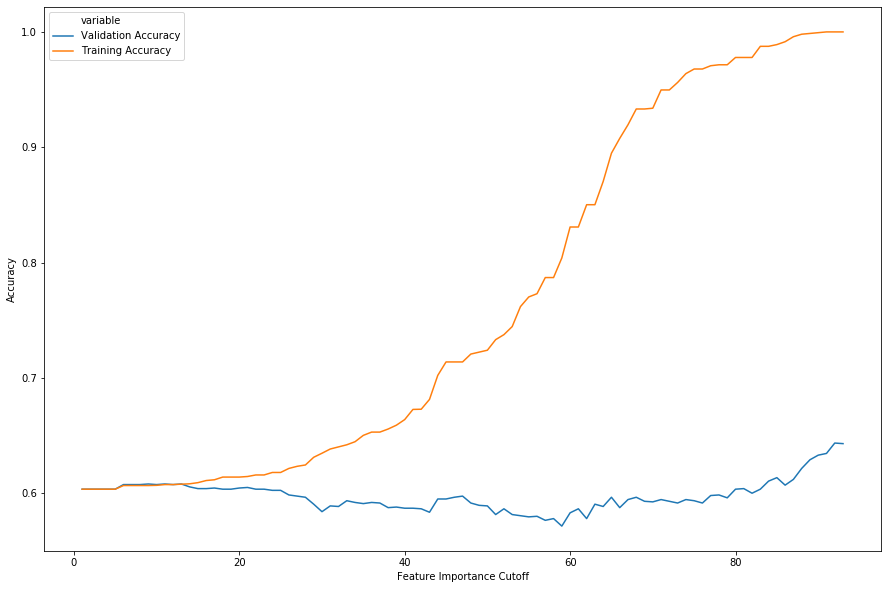

In [11]:
train_acc = []
val_acc = []
cutoff = []
for i in range(1, X_train.columns.shape[0] + 1):
    clf = RandomForestClassifier(random_state=42)
    filtered = X_train.columns[indices[:i]].tolist()
    clf.fit(X_train[filtered], Y_train)
    train_acc.append(clf.score(X_train[filtered], Y_train))
    val_acc.append(clf.score(X_val[filtered], Y_val))
    cutoff.append(i)

data = pd.DataFrame({
    'Feature Importance Cutoff': cutoff,
    'Validation Accuracy': val_acc,
    'Training Accuracy' : train_acc
})
plt.figure(figsize=(15, 10))
sns.lineplot(x='Feature Importance Cutoff', y='Accuracy', hue='variable', 
             data=pd.melt(data, ['Feature Importance Cutoff'], value_name='Accuracy'))

### Model selection:
We choose gradient boosted decision trees as our classifiers. These are very powerful models, and tend to perform well especially in our case, where the dataset is not very large.

We run a gridsearch to determine the best parameters.

The results are not very good, but seem to be on par with what other works we found, when taking into account that those tend to work with much larger datasets.

In [104]:
params = {'n_estimators': [20, 50, 100],
          'max_depth' : [3, 6, 8],
          'reg_alpha': [0, 0.2, 0.4],
          'reg_lambda' : [0.7, 1],
          'learning_rate': [0.3]}

dummy = {'n_estimators': [100],
          'max_depth' : [6],
          'reg_alpha': [0],
          'reg_lambda' : [1],
          'learning_rate': [0.3]}
opt = GridSearch(param_grid=params, model=XGBClassifier(random_state=42))
opt.fit(X_train, Y_train, X_val, Y_val)
print(opt.best_params)
clf = opt.best_estimator_
print("---- Validation ----")
predictions = clf.predict(X_val)
print("Accuracy : {}".format(accuracy_score(Y_val, predictions)))
print("F1-Score : {}".format(f1_score(Y_val, predictions)))
print(confusion_matrix(Y_val, predictions))
print("---- Test ----")
predictions = clf.predict(X_test)
print("Accuracy : {}".format(accuracy_score(Y_test, predictions)))
print("F1-Score : {}".format(f1_score(Y_test, predictions)))
print(confusion_matrix(Y_test, predictions))




  0%|          | 0/54 [00:00<?, ?it/s]


  2%|▏         | 1/54 [00:00<00:19,  2.69it/s]


 13%|█▎        | 7/54 [00:00<00:13,  3.57it/s]


 17%|█▋        | 9/54 [00:01<00:11,  4.00it/s]


 24%|██▍       | 13/54 [00:01<00:08,  4.56it/s]


 28%|██▊       | 15/54 [00:02<00:08,  4.82it/s]


 31%|███▏      | 17/54 [00:02<00:07,  5.12it/s]


 46%|████▋     | 25/54 [00:03<00:05,  5.79it/s]


 50%|█████     | 27/54 [00:03<00:03,  7.15it/s]


 57%|█████▋    | 31/54 [00:04<00:04,  4.78it/s]


 61%|██████    | 33/54 [00:06<00:06,  3.32it/s]


 65%|██████▍   | 35/54 [00:06<00:04,  4.21it/s]


 80%|███████▉  | 43/54 [00:06<00:02,  5.14it/s]


 83%|████████▎ | 45/54 [00:07<00:02,  4.09it/s]


 87%|████████▋ | 47/54 [00:07<00:01,  4.90it/s]


 91%|█████████ | 49/54 [00:09<00:01,  2.58it/s]


 94%|█████████▍| 51/54 [00:10<00:01,  2.64it/s]


100%|██████████| 54/54 [00:10<00:00,  5.05it/s]

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.4, 'reg_lambda': 1}
---- Validation ----
Accuracy : 0.6575
F1-Score : 0.45331205107741424
[[1031  176]
 [ 509  284]]
---- Test ----
Accuracy : 0.6475
F1-Score : 0.41493775933609955
[[1045  162]
 [ 543  250]]


### Try including full diagnostic information
This has many more features, due to the one hot encoding of diagnostics, so will be somewhat harder to train.

We see an improvement in the test set but no improvement in validation set, so it is hard to take conclusions from this.

In [102]:
categorical_vars = ['race', 'age', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', \
                    'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed']
numerical_vars = df_train_alt.columns[6:14].tolist()

scaler = StandardScaler()
scaler.fit(df_train_alt[numerical_vars])
X_train_alt, Y_train_alt = prepare_data(df_train_alt, scaler, categorical_vars, numerical_vars)
X_val_alt, Y_val_alt = prepare_data(df_val_alt, scaler, categorical_vars, numerical_vars)
X_test_alt, Y_test_alt = prepare_data(df_test_alt, scaler, categorical_vars, numerical_vars)

In [103]:
params = {'n_estimators': [20, 50, 100],
          'max_depth' : [3, 6],
          'reg_alpha': [0.2, 0.4],
          'reg_lambda' : [0.7, 1],
          'learning_rate': [0.3]}
opt = GridSearch(param_grid=params, model=XGBClassifier(random_state=42, verbose=True))
opt.fit(X_train_alt, Y_train_alt, X_val_alt, Y_val_alt)
print(opt.best_params)
print("---- Validation ----")
predictions = opt.predict(X_val_alt)
print("Accuracy : {}".format(accuracy_score(Y_val_alt, predictions)))
print("F1-Score : {}".format(f1_score(Y_val_alt, predictions)))
print(confusion_matrix(Y_val_alt, predictions))
print("---- Test ----")
predictions = opt.predict(X_test_alt)
print("Accuracy : {}".format(accuracy_score(Y_test_alt, predictions)))
print("F1-Score : {}".format(f1_score(Y_test_alt, predictions)))
print(confusion_matrix(Y_test_alt, predictions))




  0%|          | 0/24 [00:00<?, ?it/s]


  4%|▍         | 1/24 [00:01<00:27,  1.18s/it]


 21%|██        | 5/24 [00:02<00:17,  1.06it/s]


 38%|███▊      | 9/24 [00:06<00:14,  1.06it/s]


 71%|███████   | 17/24 [00:10<00:05,  1.26it/s]


 88%|████████▊ | 21/24 [00:15<00:02,  1.04it/s]


100%|██████████| 24/24 [00:15<00:00,  1.52it/s]

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 20, 'reg_alpha': 0.4, 'reg_lambda': 0.7}
---- Validation ----
Accuracy : 0.655
F1-Score : 0.42016806722689076
[[1060  147]
 [ 543  250]]
---- Test ----
Accuracy : 0.648
F1-Score : 0.42009884678747944
[[1041  166]
 [ 538  255]]
